In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import librosa
import librosa.display
import IPython.display as ipd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Extracting Data from Audio files

In [ ]:
audio_tap_file = "/content/drive/MyDrive/Surface_Classification_Database/Sample_Dataset/G1EpoxyRasterPlate_Sound_Tapping_train1.wav"
audio_move_file = "/content/drive/MyDrive/Surface_Classification_Database/Sample_Dataset/G1EpoxyRasterPlate_Sound_Movement_train1.wav"
acc_x_move_file = "/content/drive/MyDrive/Surface_Classification_Database/Sample_Dataset/G1EpoxyRasterPlate_Movement_X_train1.txt"
acc_y_move_file = "/content/drive/MyDrive/Surface_Classification_Database/Sample_Dataset/G1EpoxyRasterPlate_Movement_Y_train1.txt"
acc_z_move_file = "/content/drive/MyDrive/Surface_Classification_Database/Sample_Dataset/G1EpoxyRasterPlate_Movement_Z_train1.txt"
acc_tap_file = "/content/drive/MyDrive/Surface_Classification_Database/Sample_Dataset/G1EpoxyRasterPlate_Tapping_Z_train1.txt"
fric1_move_file = "/content/drive/MyDrive/Surface_Classification_Database/Sample_Dataset/G1EpoxyRasterPlate_FrictionFSR1_Movement_train1.txt"
fric2_move_file = "/content/drive/MyDrive/Surface_Classification_Database/Sample_Dataset/G1EpoxyRasterPlate_FrictionFSR2_Movement_train1.txt"

In [ ]:
ipd.Audio(audio_tap_file)

In [ ]:
data, sr = librosa.load(audio_tap_file, sr = None)
acc_data = pd.read_csv(acc_tap_file, names = ["Acceleration"])

In [ ]:
acc_data.head()

,Acceleration
0,0.001857
1,0.002182
2,0.001533
3,0.002182
4,0.002507


In [ ]:
acc_data = acc_data.to_numpy().ravel()

In [ ]:
acc_sampling_freq = 1e4

In [ ]:
tot_samples = len(data)
print("No. of sample points:", tot_samples)

No. of sample points: 10501


In [ ]:
print(f"Sampling Rate: {sr} Hz")

Sampling Rate: 44100 Hz


In [ ]:
sample_duration = 1 / sr
print(f"Sample Duration: {sample_duration:.6f} s")

Sample Duration: 0.000023 s


In [ ]:
tot_duration = sample_duration * tot_samples
print(f"Total duration: {tot_duration:.2f} s")

Total duration: 0.24 s


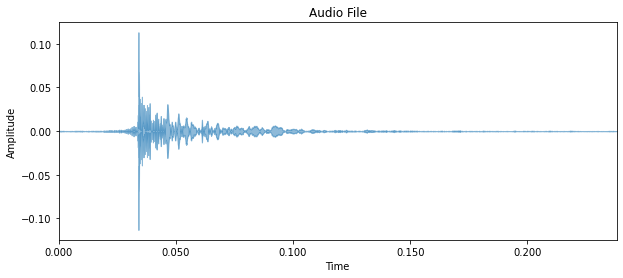

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.waveplot(data, alpha=0.5, sr = 44100)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Audio File")
plt.show()

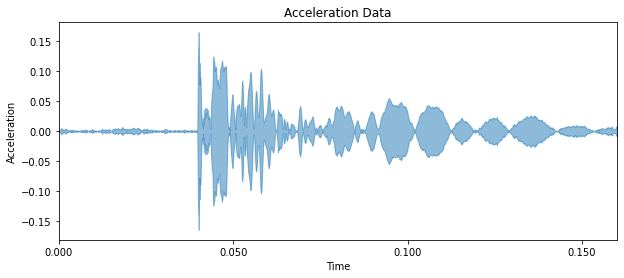

In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.waveplot(acc_data, alpha=0.5, sr = 10000)
plt.xlabel("Time")
plt.ylabel("Acceleration")
plt.title("Acceleration Data")
plt.show()

# Acceleration Features

In [ ]:
# Acceleration Data
acc_x_move_data = pd.read_csv(acc_x_move_file, names = ["Acceleration_X_Move"]).to_numpy().ravel()
acc_y_move_data = pd.read_csv(acc_y_move_file, names = ["Acceleration_Y_Move"]).to_numpy().ravel()
acc_z_move_data = pd.read_csv(acc_z_move_file, names = ["Acceleration_Z_Move"]).to_numpy().ravel()
acc_tap_data = pd.read_csv(acc_tap_file, names = ["Acceleration_Tap"]).to_numpy().ravel()

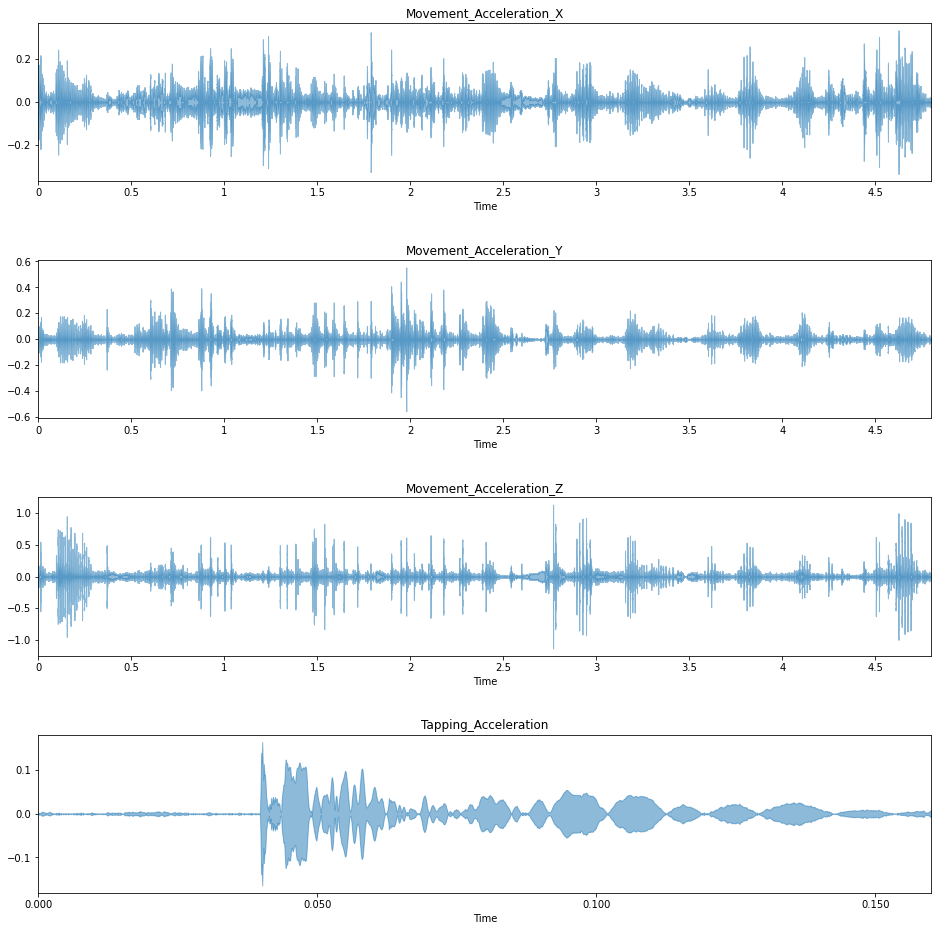

In [ ]:
# Plotting Acceleration
fig = plt.figure(figsize=(16, 16))
plt.subplots_adjust(hspace=0.5)

ax1 = plt.subplot(411)
ax1.set_title('Movement_Acceleration_X')
librosa.display.waveplot(acc_x_move_data, alpha=0.5, sr = 10000)

ax2 = plt.subplot(412)
ax2.set_title('Movement_Acceleration_Y')
librosa.display.waveplot(acc_y_move_data, alpha=0.5, sr = 10000)

ax3 = plt.subplot(413)
ax3.set_title('Movement_Acceleration_Z')
librosa.display.waveplot(acc_z_move_data, alpha=0.5, sr = 10000)

ax4 = plt.subplot(414)
ax4.set_title('Tapping_Acceleration')
librosa.display.waveplot(acc_tap_data, alpha=0.5, sr = 10000)
plt.show()

#### Modified Frequency Cepstral Coefficients (MFCC)

In [ ]:
mfccs = librosa.feature.mfcc(y=acc_x_move_data, n_mfcc=13, sr=1e4, lifter = 0)
mfccs.shape

(13, 94)

#### Acceleration Impact Hardness (AIH)

In [ ]:
def bandPassFilter(data, sr, low, high):
  low = 1 / (0.5*sr)
  high = 12 / (0.5*sr)
  order = 2
  b, a = sp.signal.butter(order, [low, high], 'bandpass', analog = False)
  y = sp.signal.filtfilt(b,a,data)
  return y

In [ ]:
def AIH(acc_data, sr):

  # Calculating Impact Time
  acc_data = abs(acc_data)
  max_acc = acc_data[0]
  i = 0

  # If the new_amplitude is 5 times the max amplitude till now, then we consider it to be an impact.
  while acc_data[i] < 5*max_acc:
    max_acc = max(max_acc, acc_data[i])
    i+=1
  i-=1
  impact_time = i/sr
  print(f'Imapct time: {impact_time:.2f}s')

  # Calculating hand acceleration data
  h_acc = acc_data[(3*i)//4:i+1] # Last 1/4th of the total time before impact
  h_acc = bandPassFilter(h_acc, sr, 1, 12) # Taking the low frequency component of h_acc from 1 to 12 hz

  # Calculating max-impact and temporal centroid relative to start of impact
  tot_samples = len(acc_data)
  sample_duration = 1 / sr
  tot_duration = sample_duration * tot_samples
  print(f'Total time: {tot_duration:.2f}s')

  impact_data = np.abs(acc_data[i+1:])
  time = np.linspace(0, tot_duration, tot_samples)
  impact_time = np.linspace(0, tot_duration - impact_time, len(impact_data))

  combined_data = np.stack([impact_data, impact_time], axis = 1)
  combined_data = combined_data[combined_data[:, 0].argsort()][::-1]

  max_impact = combined_data[0, 0]
  print(f'Max Impact: {max_impact:.2f} m/s\u00b2')
  temporal_centroid = np.dot(combined_data[:3, 0], combined_data[:3, 1]) / np.sum(combined_data[:3, 0])
  print(f'Temporal Centroid (relative to impact time): {temporal_centroid:.4f}s')
  print(f'Hand Velocity: {np.sum(h_acc):.4f} m/s')
  return max_impact / (temporal_centroid * np.sum(h_acc))

sr = 10000
aih = AIH(acc_tap_data, sr)
print(f"AIH: {aih:.2f}")

Imapct time: 0.04s
Total time: 0.16s
Max Impact: 0.16 m/s²
Temporal Centroid (relative to impact time): 0.0015s
Hand Velocity: 0.0001 m/s
AIH: 2210909.77


## Discrete Cosine Transform (DCT)

In [ ]:
dct = sp.fft.dct(data, n = 4096)
frequency = np.linspace(0, sr, len(dct))

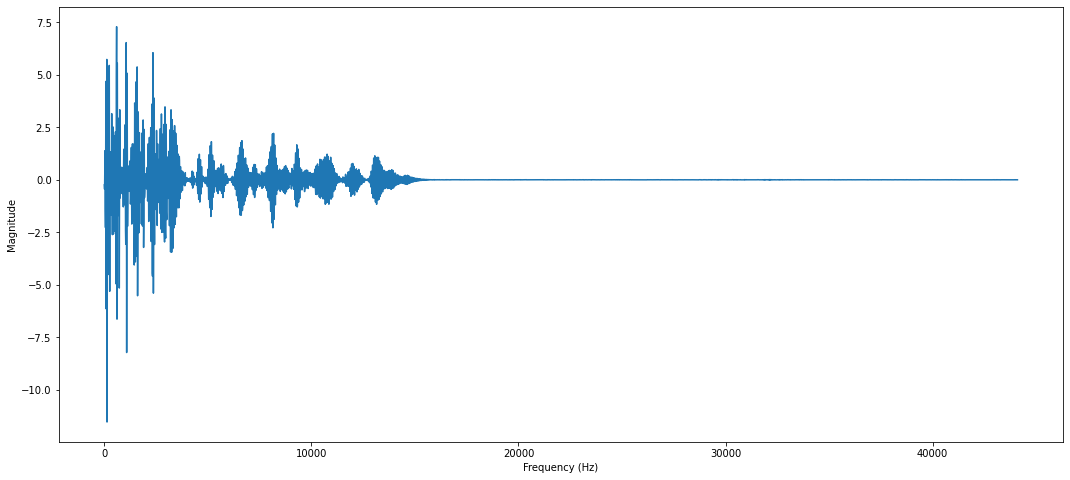

In [ ]:
plt.figure(figsize=(18, 8))
plt.plot(frequency, dct)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

## Sound Impact Spectral Centroid (SISC) 

In [ ]:
def SISC(dct):
  m = len(dct)
  amp = dct[:m//2]
  freq = np.linspace(0, sr, len(dct))[:m//2]
  sisc = (np.sum((amp**2)*freq)) / np.sum((amp**2))
  return sisc

sisc = SISC(dct)
print(f"SISC: {sisc:.2f} Hz")

SISC: 2315.76 Hz


## Sound Impact Spectral Spread (SISS)

In [ ]:
def SISS(dct):
  m = len(dct)
  amp = dct[:m//2]
  freq = np.linspace(0, sr, len(dct))[:m//2]
  sisc = SISC(dct)
  siss = np.sum(((freq-sisc)**2) * (amp**2)) / np.sum(amp**2)
  # print(f"SISS: {siss:.2f}")
  siss = np.sqrt(siss)
  return siss

siss = SISS(dct)
print(f"SISS: {siss:.2f} Hz")

SISS: 2796.14 Hz


## Sound Impact Spectral Roll-off (SISR)

In [ ]:
def SISR(dct, frequency):
  sum_amp = np.sum(dct**2)
  curr_sum = 0
  sisr = 0

  for i in range(len(dct)):
    if curr_sum >= 0.95*sum_amp:
      sisr = frequency[i]
      break
    else:
      curr_sum += dct[i]**2
  return sisr

sisr = SISR(dct, frequency)
print(f"SISR: {sisr:.2f} Hz")

SISR: 9250.77 Hz


## Sound Movement Low-High Ratio (SMLH)

In [ ]:
def SMLH(dct, lower_threshold, higher_threshold):
  lower_idx = (lower_threshold * len(dct)) // sr
  higher_idx = (higher_threshold * len(dct)) // sr
  lower_mean = np.sum(np.abs(dct)[:lower_idx])/lower_idx
  higher_mean = np.sum(np.abs(dct)[lower_idx:higher_idx])/(higher_idx - lower_idx)
  smlh = lower_mean/higher_mean
  return smlh

smlh = SMLH(dct, 400, 1000)
print(f"SMLH: {smlh:.2f}")

SMLH: 1.49


## Sound Impact Hardness (SIH)

In [ ]:
def bandPassFilter(data, sr):
  low = 1 / (0.5*sr)
  high = 12 / (0.5*sr)
  order = 2
  b, a = sp.signal.butter(order, [low, high], 'bandpass', analog = False)
  y = sp.signal.filtfilt(b,a,data)
  return y

In [ ]:
def SIH(data, sr, acc_data):

  acc_data = abs(acc_data)
  max_acc = acc_data[0]
  i = 0
  while acc_data[i] < 5*max_acc:
    max_acc = max(max_acc, acc_data[i])
    i+=1
  i-=1
  h_acc = bandPassFilter(acc_data[:i+1], 10000)

  tot_samples = len(data)
  sample_duration = 1 / sr
  tot_duration = sample_duration * tot_samples

  time = np.linspace(0, tot_duration, tot_samples)
  combined_data = np.stack([np.abs(data), time], axis = 1)
  combined_data = combined_data[combined_data[:, 0].argsort()][::-1]

  max_impact = combined_data[0, 0]
  temporal_centroid = np.dot(combined_data[:3, 0], combined_data[:3, 1]) / np.sum(combined_data[:3, 0])
  
  return max_impact / (temporal_centroid * np.sum(h_acc))

sih = SIH(data, sr, acc_data)
print(f"SIH: {sih:.2f}")

SIH: 224.14


## Sound Impact Spectral Harmonic (SISH)

In [ ]:
def SISH(dct, frequency):
  mean = np.mean(dct)
  var = np.var(dct)
  ndata = (dct - mean)/var
  auto_corr = np.correlate(ndata, ndata, mode = "full")
  auto_corr = auto_corr[len(auto_corr)//2:]
  auto_corr = auto_corr/len(auto_corr)

  diff_auto_corr = auto_corr[1:] - auto_corr[:-1]
  diff_auto_corr = [max(0, diff_auto_corr[i]) for i in range(len(diff_auto_corr))]
  diff_auto_corr.insert(0, diff_auto_corr[0])
  diff_auto_corr = np.array(diff_auto_corr)

  sish = np.dot(diff_auto_corr, frequency) / np.sum(diff_auto_corr)
  return sish

sish = SISH(dct, frequency)
print(f"SISH: {sish:.2f} Hz")                                             

SISH: 4593.88 Hz
